<a href="https://colab.research.google.com/github/gani88/ForecastingTimeSeries/blob/main/Forecasting_5_Hybrid_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction: Harnessing the Power of Hybrid Forecasting

In the world of predictive modeling, different algorithms possess unique strengths and limitations. Linear regression, for instance, is adept at extending trends beyond known data points, while XGBoost shines at capturing intricate interactions within complex datasets. Yet, neither algorithm is without its constraints. Linear regression struggles with capturing intricate interactions, while XGBoost finds it challenging to extend trends.

In this enlightening journey (**hahaha :)** ), we delve into the realm of hybrid forecasting, a dynamic approach that capitalizes on the best of both worlds. The concept is simple yet revolutionary: by blending the capabilities of two complementary learning algorithms, we can create forecasters that not only extrapolate trends but also adeptly learn intricate interactions within the data.

## Part of the Hybrid


To create effective hybrid forecasting models, it's important to gain a deeper understanding of the fundamental structure of time series data. In our exploration so far, we've identified three key patterns of dependence: trends, seasons, and cycles. Remarkably, many time series can be accurately described using a simple additive model composed of these components, along with a random error that is essentially unpredictable:

Series = Trend + Seasons + Cycles + Error

In this model, each term represents a distinct **component** of the time series.

The **residuals** of a model refer to the discrepancies between the actual target values and the predictions generated by the model. In simpler terms, they capture what the model couldn't accurately capture or predict. When you plot these residuals against a specific feature, you're essentially visualizing the portion of the target that remains unaccounted for after considering that feature.

In essence, understanding these components and analyzing residuals can guide us in building more effective hybrid forecasting models. By comprehending the various elements that contribute to a time series and recognizing where predictive models fall short, we're better equipped to create hybrid models that harness the strengths of different algorithms to provide more accurate and comprehensive forecasts.

*Image from kaggle learn*
![image](https://storage.googleapis.com/kaggle-media/learn/images/mIeeaBD.png)

In the illustration shown in the left part of the figure, we have a segment of the Tunnel Traffic time series alongside the trend-seasonal curve. When we subtract the trend-seasonal curve from the original series, what remains on the right side of the figure are the residuals. These residuals encapsulate all the aspects of the Tunnel Traffic series that the trend-seasonal model failed to capture or comprehend. In other words, they embody the information that was left unaccounted for by the model's trend and seasonal components.

## Hybrid forecast with residuals

Previously, we employed a single algorithm, namely linear regression, to simultaneously learn all the various components of a time series. However, it's also possible to adopt a hybrid approach where different algorithms are used to tackle specific components individually. This method allows us to leverage the strengths of each algorithm optimally for different aspects of the data. To implement this, we initially employ one algorithm to model the original series and then use another algorithm to handle the residuals of the initial model.

The process unfolds as follows:


---


Training and Prediction with the First Model:

Train the first model (model_1) using specific training data (X_train_1, y_train).
Predict the target values (y_pred_1) using the trained model (model_1) on the same training data (X_train).


Training and Prediction with the Second Model on Residuals:

Train the second model (model_2) using specific training data (X_train_2) and the difference between the actual target (y_train) and the predictions from the first model (y_pred_1).
Predict the target values (y_pred_2) using the trained model (model_2) on the same training data (X_train_2).

Combining Predictions for Overall Forecasts:

Combine the predictions from the first and second models (y_pred_1 and y_pred_2) to obtain the overall predictions (y_pred).



```
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# Step 1: Train and predict with the first model (linear regression)
model_1 = LinearRegression()
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_train)

# Step 2: Train and predict with the second model (GBDT) on residuals
residuals = y_train - y_pred_1
model_2 = GradientBoostingRegressor()
model_2.fit(X_train_2, residuals)
y_pred_2 = model_2.predict(X_train_2)

# Step 3: Combine predictions for overall forecasts
y_pred = y_pred_1 + y_pred_2

```




---

It's important to note that distinct feature sets (X_train_1 and X_train_2) can be used for each model, depending on the specific component we aim for each model to learn. For instance, if the first model is designed to capture the trend, there may be no need to include a trend-related feature for the second model.

While it's theoretically possible to employ more than two models, in practice, it's often not significantly beneficial. The most common approach is the one described above: initiating with a simpler learning algorithm (often linear) and then employing a more powerful and complex algorithm, such as Gradient Boosted Decision Trees (GBDTs) or deep neural networks, to further refine the predictions. The simpler model serves as a supportive "helper" for the more robust algorithm that follows.

### How to design it

Regression algorithms typically predict outcomes in two main ways: by changing the features or by altering the target variable. Feature-transforming algorithms learn a mathematical function that takes the features as input, combines them, and transforms them to produce outputs that closely match the target values in the training data. Examples of such algorithms include linear regression and neural networks.

On the other hand, target-transforming algorithms use the features to group the target values in the training data. They make predictions by averaging the values within a group; the features help identify which group to average. Decision trees and nearest neighbors are examples of target-transforming algorithms.

Here's the key takeaway: Feature-transforming algorithms are typically able to forecast target values beyond the training data if given appropriate features. However, predictions made by target-transforming algorithms will always remain within the range of the training data. For instance, if the time dummy feature keeps counting time steps, linear regression will continue to draw the trend line. If you provide the same time dummy, a decision tree will predict the trend indicated by the last step of the training data indefinitely into the future. However, decision trees cannot extend these trends beyond their observed range. Random forests and gradient boosted decision trees (like XGBoost) are collections of decision trees, which means they also share this limitation of not being able to extrapolate trends beyond what's observed in the training data.

We use linear regression to predict and extend trends, then modify the target to eliminate the trend, and finally apply XGBoost to the trend-removed residuals. This way, linear regression capitalizes on its strength to anticipate trends, and XGBoost refines its predictions by working on the remaining patterns.

For neural networks or other algorithms that transform features, you can hybridize them differently. Instead of relying solely on their predictions, you can integrate the predictions of another model as features. These predictions then become part of the neural network's own forecast. The technique of training on residuals aligns with the methodology employed by gradient boosting, leading us to term these blended models as "boosted hybrids." On the other hand, the strategy of incorporating predictions as features is known as "stacking," resulting in models we refer to as "stacked hybrids."

# Example

I will use dataset same from kaggle which called US Retail Sales. I write this example is just for my learning habit and experimenting with my own way.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

plt.style.use("seaborn-whitegrid")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(12, 6),
    titlesize=18,
    titleweight='bold'
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10
)
plot_params = dict(
    color="0.75",
    style=".-",
    markededgecolor="0.25",
    markerfacecolor="0.25"
)

industries = ["BuildingMaterials", "FoodAndBeverage"]
retail = pd.read_csv("/content/us-retail-sales.csv", usecols=['Month'] + industries,parse_dates=['Month'], index_col='Month').to_period('D').reindex(columns=industries)
retail = pd.concat({'Sales': retail}, names=[None, 'Industries'], axis=1)

retail.head()

In [4]:
retail.head(10)

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677
1992-06-01             12219           30769
1992-07-01             11658           32402
1992-08-01             11219           31469
1992-09-01             11309           30162
1992-10-01             11605           31407

Then we create linear regression to learn trend for each series

In [ ]:
y = retail.copy()

# Trend features
dp = DeterministicProcess(
    index=y.index, # dates from train data
    constant=True, # intercept
    order=2,       # quadratic trend
    drop=True     # dropping terms to avoid collinearity
)

X = dp.in_sample() # this is feature for training data

# Testing on the years 2016 - 2019. Splitting the date index rather than dataframe directly (for easier purpose)
idx_train, idx_test = train_test_split(y.index, test_size=12*4, shuffle=False)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

# Fit
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

# For predictions
y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns
)

y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns
)



<ipython-input-37-5c2f562ffd55>:3: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
<ipython-input-37-5c2f562ffd55>:4: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
<ipython-input-37-5c2f562ffd55>:5: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)


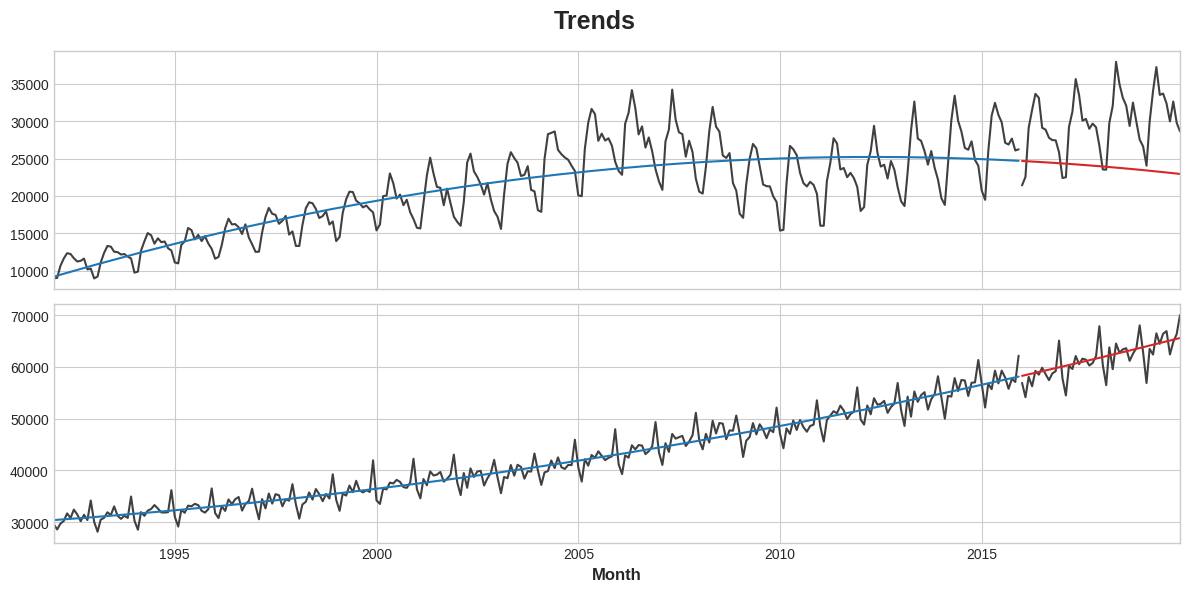

In [37]:
# Plotting
axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)

for ax in axs: ax.legend([])
_ = plt.suptitle("Trends")

In [12]:
X_train.tail()

,const,trend,trend_squared
Month,,,
2015-08-01,1.0,284.0,80656.0
2015-09-01,1.0,285.0,81225.0
2015-10-01,1.0,286.0,81796.0
2015-11-01,1.0,287.0,82369.0
2015-12-01,1.0,288.0,82944.0


In [11]:
X_test.head()

,const,trend,trend_squared
Month,,,
2016-01-01,1.0,289.0,83521.0
2016-02-01,1.0,290.0,84100.0
2016-03-01,1.0,291.0,84681.0
2016-04-01,1.0,292.0,85264.0
2016-05-01,1.0,293.0,85849.0


In [24]:
y_train.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

In [25]:
y_test.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
2016-01-01             21408           56931
2016-02-01             22538           54145
2016-03-01             29101           58086
2016-04-01             31497           56266
2016-05-01             33652           59242

In [16]:
y.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01              8964           29589
1992-02-01              9023           28570
1992-03-01             10608           29682
1992-04-01             11630           30228
1992-05-01             12327           31677

In [17]:
y_fit.head()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
1992-01-01       9192.966040    30384.413252
1992-02-01       9324.354900    30430.803516
1992-03-01       9455.202650    30477.545559
1992-04-01       9585.509289    30524.639380
1992-05-01       9715.274818    30572.084979

In [18]:
y.tail()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
2019-08-01             32375           66937
2019-09-01             29963           62420
2019-10-01             32629           64849
2019-11-01             29793           66363
2019-12-01             28621           70028

In [19]:
y_pred.tail()

Sales                
Industries BuildingMaterials FoodAndBeverage
Month                                       
2019-08-01      23129.938678    64951.978684
2019-09-01      23082.220023    65114.807664
2019-10-01      23033.960257    65277.988422
2019-11-01      22985.159382    65441.520959
2019-12-01      22935.817396    65605.405275